In [1]:
import tensorflow as tf
import keras
import os
import time
import numpy as np
import io
import random
from matplotlib import pyplot as plt
from scipy.ndimage import rotate
from keras import backend as K

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
10


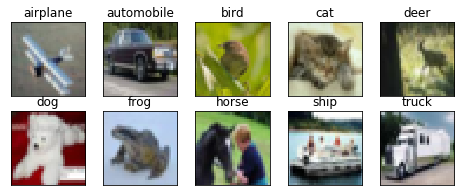

In [2]:
# Load cifar dataset using the load data function
# The data is in the shape of (Batch_size, num_channel, width, height)
# np.unique returns unique class names
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) =  cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_classes)

# Visualization of some particular classes from the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5,1 + i, xticks=[], yticks=[])
    # gets the all the position of a particular class
    idx = np.where(train_labels[:]==i)[0]
    # using the idx we can find the corresponding image arrays
    features_idx = train_features[idx,::]
    # selects an img num by random
    img_num = np.random.randint(features_idx.shape[0])
    # gets the img array by img num
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [3]:
type(class_names.index('cat'))

int

In [0]:
# Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# Convert class labels to binary class labels
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [0]:
class custom_class:
    # todo read about class and method inheritance best practices
    # todo write comments for arguments
    # todo i am using class inside class, it shoud be only methods and one parent class ?
    def bytes_feature(self, value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def int64_feature(self, value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def create_tf_record_custom(self, features, labels, output_dir):
        with tf.python_io.TFRecordWriter(output_dir) as file:
            for i, each_feature in (enumerate(features)):
                data = each_feature
                label = np.argmax(labels[i])
                example = tf.train.Example(features=tf.train.Features(
                    feature={
                        'image': self.bytes_feature(data.tobytes()),
                        'label': self.int64_feature(label)
                    }))
                file.write(example.SerializeToString())

    class show_and_plt_custom():
        # todo write methods instead of using 2 class
        # todo write plot function seperately
        def plot_images_ParticularClass(images, img_labels, galery_size,
                                        type_images):

            label_value = class_names.index(type_images)
            img_labels = img_labels.tolist()  #todo index from numpy array
            images_to_plot_labels_index = [
                img_labels.index(i) for i in img_labels
                if np.argmax(i) == label_value
            ]
            images_to_plot_labels_index = random.sample(
                images_to_plot_labels_index, 1)
            fig, axes = plt.subplots()
            axes.set_title('true_label = ' + str(class_names[label_value]),
                           fontsize=20)
            axes.imshow(np.squeeze(images[images_to_plot_labels_index]))

        def plot_images_random(images,
                               img_labels,
                               galery_size,
                               type_images='random'):

            images_to_plot = random.sample(range(0, len(images)),
                                           galery_size * galery_size)
            images_to_plot_labels = [
                np.argmax(img_labels[i]) for i in images_to_plot
            ]
            fig, axes = plt.subplots(galery_size,
                                     galery_size,
                                     figsize=(30, 30))
            for i in range(galery_size):
                for j in range(galery_size):
                    lbl = images_to_plot_labels[i + j]
                    img = images[images_to_plot[i + j]]
                    axes[i, j].set_title('true_label = ' +
                                         str(class_names[lbl]),
                                         fontsize=20)
                    axes[i, j].imshow(img)

        def plot_images_misclassified(images,
                                      img_labels,
                                      galery_size,
                                      miss_class_index,
                                      type_images='misclassified'):

            fig, axes = plt.subplots(5, 5, figsize=(30, 30))
            for i in range(galery_size):
                for j in range(galery_size):
                    Y_test_true_label = miss_class_index[i + j][2]
                    Y_test_pred_label = miss_class_index[i + j][1]
                    X_test_image = images[miss_labels[i + j][0]]

                    axes[i, j].set_title(
                        'true = ' + str(class_names[Y_test_true_label]) +
                        ' , pred = ' + str(class_names[Y_test_pred_label]),
                        fontsize=20)
                    axes[i, j].imshow(X_test_image)

    def rotate_image(self, img, deg_of_rot):
        # todo using scipy image rotaion, change it to native tensorflow method
        new_img = rotate(img, deg_of_rot)
        return new_img

    def flip_image(self, img):
        # todo flip should be random(some images shouldn't be fliped up)
        img = np.fliplr(img)
        return img

    def random_crop(self, input_img, padd_value, crop_value):
        final_img_w, final_img_h = input_img.shape[
            0] + padd_value, input_img.shape[1] + padd_value
        padded_img = tf.image.resize_with_crop_or_pad(input_img, final_img_w,
                                                      final_img_h)
        cropped_image = tf.image.random_crop(padded_img,
                                             size=[crop_value, crop_value, 3])
        return K.eval(cropped_image)

    def cutout_with_random_erasing(self,
                                   p=0.5,
                                   s_l=0.02,
                                   s_h=0.4,
                                   r_1=0.3,
                                   r_2=1 / 0.3,
                                   v_l=0,
                                   v_h=255,
                                   pixel_level=False):
        # todo make sense out of the values so that we can control it by passing pixcel values
        def eraser(input_img):
            img_h, img_w, img_c = input_img.shape
            p_1 = np.random.rand()

            if p_1 > p:
                return input_img

            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

            return input_img

        return eraser

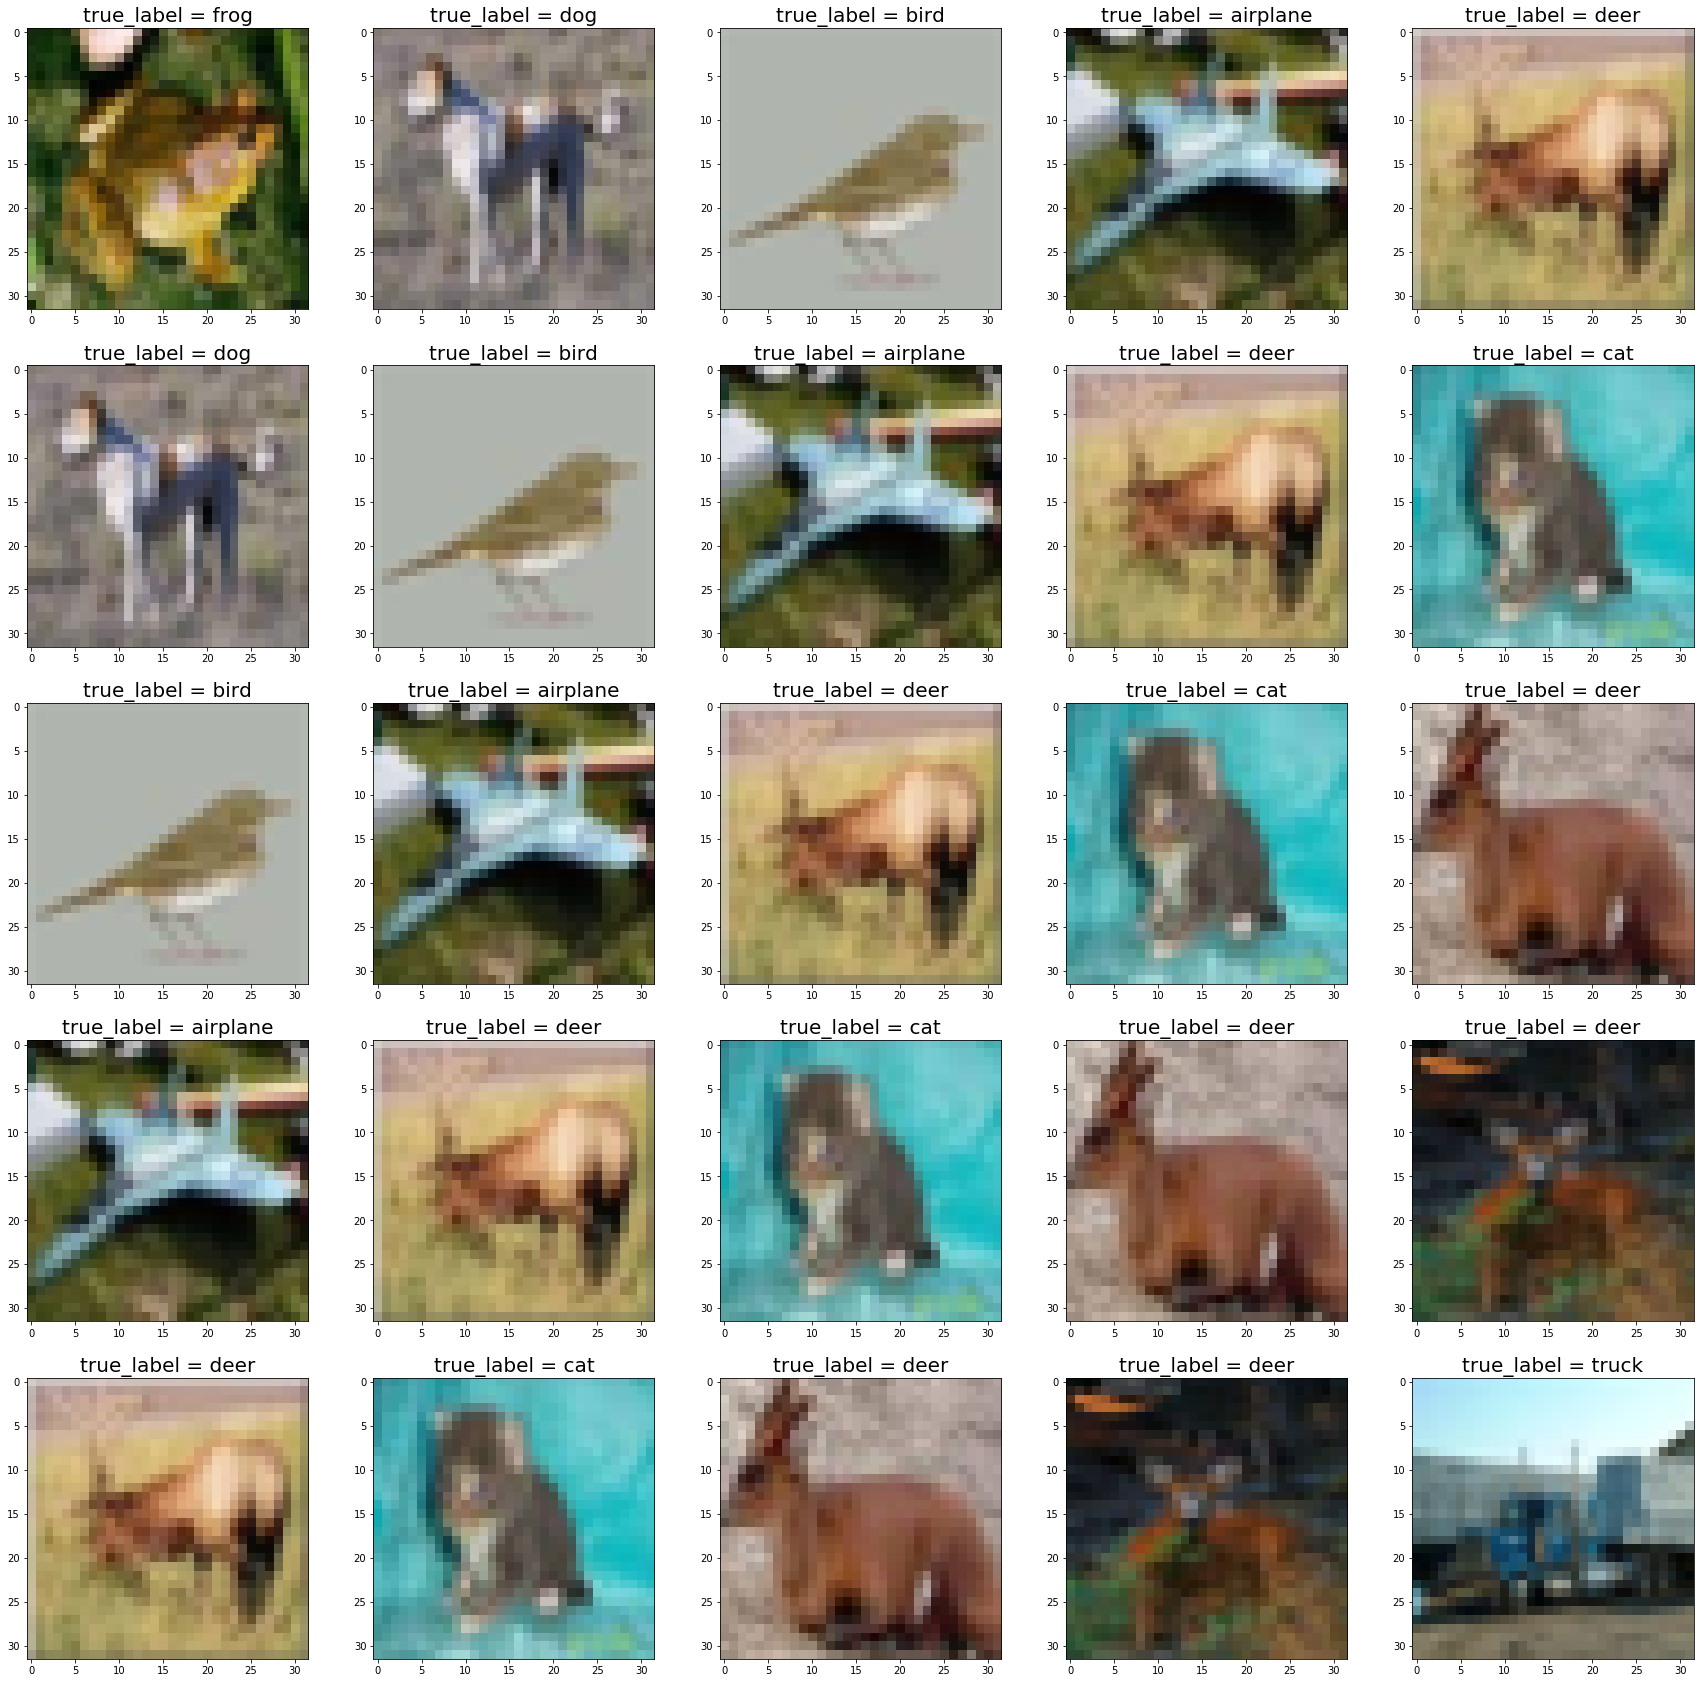

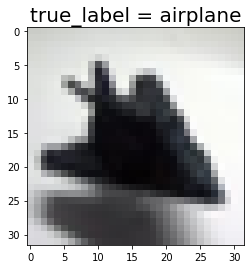

In [6]:
# # intstantiate class
my_class_custom = custom_class()
my_class_custom.create_tf_record_custom(train_features,train_labels,'./test.tfrecorfd')
my_class_custom.show_and_plt_custom.plot_images_random(train_features,train_labels,5,'random')
my_class_custom.show_and_plt_custom.plot_images_ParticularClass(train_features,train_labels,5,'airplane')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


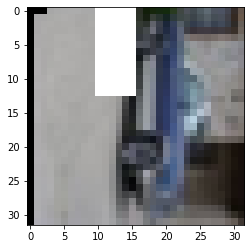

In [7]:
# intstantiate class
my_class_custom = custom_class()
img = my_class_custom.rotate_image(train_features[10000], 90)
img = my_class_custom.cutout_with_random_erasing()(img)
img = my_class_custom.flip_image(img)
img = my_class_custom.random_crop(img,4,32)
plt.imshow(img)